In [1]:
from typing import Union, Dict
from enum import Enum, unique

import pandas as pd
import os
import time

import urllib
import requests
import ssl
import certifi

from random import randint

from datetime import datetime
from pytz import timezone

from bs4 import BeautifulSoup

import threading
import IPython

# Used for debugging; pretty print JSON strings
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [12]:
if not os.path.exists('/content/drive/MyDrive/'):
    raise Exception("Error: Mount Google Drive before continuing!")

BASE_DIR = '/content/drive/MyDrive/Data Science for Social Good - Spring 2022/data/'

# Define directory that contains intermediate SSL certificates
CERT_DIR = BASE_DIR + 'certificates/'

# Define directories to save data
SCRAPE_DIR = BASE_DIR + 'scraped_files/'
DATA_DIR = SCRAPE_DIR + 'DATA/'

current_date = datetime.now(timezone('US/Eastern')).strftime("%m-%d-%Y")

# Create all directories on the given paths if needed
os.makedirs(DATA_DIR + current_date, exist_ok=True)
print("Date used for scraping:", current_date)

Date used for scraping: 03-17-2022


# Helper Functions and Classes

In [4]:
@unique
class CountyWithCaptcha(Enum):
    DESOTO = 'DeSoto'
    FORREST = 'Forrest'
    HANCOCK = 'Hancock'
    HARRISON = 'Harrison'
    LAMAR = 'Lamar'
    MARION = 'Marion'
    PERRY = 'Perry'
    YAZOO = 'Yazoo'

    # Return Name, rather than CountyWithCaptcha.Name
    def __str__(self):
        return self.name


@unique
class CountyWithoutCaptcha(Enum):
    # The commented out counties only have the total bond, not bond by crime
    # PEARL_RIVER = 'PearlRiver'
    JACKSON = 'Jackson'
    # MADISON = 'Madison'
    # # ADAMS = 'Adams'
    # # CLAY = 'Clay'
    # # JONES = 'Jones'
    # # TUNICA = 'Tunica'

    # Return Name, rather than CountyWithoutCaptcha.Name
    def __str__(self):
        return self.name


# Define a custom type to pass into functions
County = Union[CountyWithCaptcha, CountyWithoutCaptcha]


def get_county_filename(county: County) -> str:
    return f'{str(current_date)}_{county.value}.csv'

In [5]:
jail_captcha_links = {
    CountyWithCaptcha.DESOTO: 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/DeSoto_County_MS/',
    CountyWithCaptcha.FORREST: 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/Forrest_County_MS/',
    CountyWithCaptcha.HANCOCK: 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/HANCOCK_COUNTY_MS/',
    CountyWithCaptcha.HARRISON: 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/HARRISON_COUNTY_JAIL_MS/',
    CountyWithCaptcha.LAMAR: 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/Lamar_County_MS/',
    CountyWithCaptcha.MARION: 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/Marion_County_MS/',
    CountyWithCaptcha.PERRY: 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/Perry_County_MS/',
    CountyWithCaptcha.YAZOO: 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/Yazoo_County_MS/',
}

In [6]:
def read_url(request: Union[str, urllib.request.Request]) -> str:
    NUM_SECONDS_TIMEOUT = 10

    ctx = ssl.create_default_context(ssl.Purpose.CLIENT_AUTH, cafile=certifi.where())
    response = urllib.request.urlopen(request, timeout=NUM_SECONDS_TIMEOUT, context=ctx)
    data = response.read()
    response.close()
    return data


def read_url_with_retries(request: str, county: County) -> str:
    if county in {CountyWithoutCaptcha.ADAMS, CountyWithoutCaptcha.MADISON}:
        user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
        headers = {'User-Agent': user_agent}
        request = urllib.request.Request(request, headers=headers)

    # Try the connection until success or NUM_ATTEMPTS is exceeded
    NUM_ATTEMPTS = 4
    for _ in range(NUM_ATTEMPTS):
        try:
            return read_url(request)
        except urllib.error.URLError as str_error:
            time.sleep(0.5)
            print("Exception:", county, str_error)

    print("Request failed for", county)
    return None

# Add missing intermediate SSL certificates

---

This should only be run once per session.

According to https://stackoverflow.com/a/64835339, Python cannot automatically download intermediate SSL certificates. 

For Jackson, this results in an SSL: CERTIFICATE_VERIFY_FAILED error. We add the intermediate certificates found at: https://services.co.jackson.ms.us/jaildocket/_inmateList.php

In [7]:
with open(certifi.where(), 'a') as global_cert_file:
    for filename in os.listdir(CERT_DIR):
        with open(CERT_DIR + filename, 'r') as missing_cert_file:
            cert_data = missing_cert_file.read()
            global_cert_file.write('\n' + cert_data)

# Counties with Captchas Scraper

---



In [8]:
def county_with_captcha_scraper(county: CountyWithCaptcha, captcha_key: str):
    jail_url = jail_captcha_links[county]
    jail_record_data = requests.post(
        jail_url,
        json={'captchaKey': captcha_key}
    )
    jail_record_data_json = jail_record_data.json()
    offender_view_key = jail_record_data_json['offenderViewKey']
    num_offenders = len(jail_record_data_json['offenders'])
    print(county, "Number of offenders:", num_offenders)

    def get_inmate_url(arrest_num: str) -> str:
        def gen_random_num_with_n_digits(n: int) -> int:
            """Based on:
            https://stackoverflow.com/a/2673399
            """
            range_start = 10 ** (n - 1)
            range_end = (10 ** n) - 1
            return randint(range_start, range_end)

        # Apparently the offender view key is just a random number (and the length doesn't matter)?
        # We need an offender view key to make our request
        # We use the default length that the website uses, which is 9
        LEN_VIEW_KEY = 9
        random_offender_view_key = gen_random_num_with_n_digits(LEN_VIEW_KEY)
        return f'{jail_url}{arrest_num}/offenderbucket/{random_offender_view_key}'

    offender_data = []
    cur_num_processed = 0
    for offender in jail_record_data_json['offenders']:
        arrest_num = offender['arrestNo']
        inmate_url = get_inmate_url(arrest_num)
        inmate_data = requests.post(
            inmate_url,
            json={'captchaKey': captcha_key}
        )
        inmate_data_json = inmate_data.json()

        # Add basic data
        inmate = {
            'Arrest Number': arrest_num,
            'Cases': inmate_data_json['cases'],
            'Charges': inmate_data_json['charges'],
        }

        # Add special fields
        for field in inmate_data_json['offenderSpecialFields']:
            field_name = field['labelText'].strip(':')
            inmate[field_name] = field['offenderValue']

        offender_data.append(inmate)
        cur_num_processed += 1
        if cur_num_processed % 50 == 0:
            print(county, "Processed", cur_num_processed)

    filename = get_county_filename(county)
    df = pd.DataFrame(offender_data)
    df.to_csv(f'{DATA_DIR}{current_date}/{filename}')

# Jackson Script

---

In [9]:
def jackson():
    def parse_inmate_card(page_data: BeautifulSoup) -> Dict:
        """
        Return info card and offense card details

        Example html scraped of an offense box
        [<div class="offenseItem"><p class="offenseTitle">POSSESSION WITH INTENT TO DISTRIBUTE A CONTROLLED SUBSTANCE</p><p class="offenseDetails">Felony - Bond: $0.00</p></div>, <div class="offenseItem"><p class="offenseTitle">POSSESSION OF A CONTROLLED SUBSTANCE - ALL OTHERS</p><p class="offenseDetails">Felony - Bond: $0.00</p></div>, <div class="offenseItem"><p class="offenseTitle">TRAFFICKING IN CONTROLLED SUBSTANCES</p><p class="offenseDetails">Felony - Bond: $0.00</p></div>]

        Example html scraped of an info box (the fields are always in the same order)
        [<p class="ilFieldName">Black Male</p>, <p class="ilFieldName">170 Pounds</p>, <p class="inmateInfo">5 Ft. 08 In. </p>, <p class="inmateInfo">Brown      Eyes </p>, <p class="inmateInfo">35 Years Old</p>, <p class="inmateInfo">Booking #:NJCADC0000023672</p>, <p class="inmateInfo red">Not Bondable</p>]

        """
        # Parse offenses 
        # Offenses is a list of dictionaries, where each dictionary contains information about the crime
        offenses = []
        offense_box = page_data.find('article', class_='ofcard').find_all('div', class_='offenseItem')
        for offense in offense_box:
            offense_title = offense.find('p', class_='offenseTitle').text
            offense_details = offense.find('p', class_='offenseDetails').text.split()
            offenses.append({
                'chargeDescription': offense_title, 
                'bondAmount': offense_details[-1][1:],
                'crimeType': offense_details[0],
            })

        def get_formatted_height(height: str) -> str:
            return f'''{height[0]}' {height[2]}"'''

        # Parse basic details: height, eye color, age etc.
        # Some of the basic details are out of order since some are missing (default missing to empty string)
        inmate_info_box = page_data.find_all('p', class_='inmateInfo')
        if len(inmate_info_box) == 5:
            height_string = inmate_info_box[0].text.split()
            height = get_formatted_height(height_string)
            eye_color = inmate_info_box[1].text.split()[0]
            age = inmate_info_box[2].text.split()[0]
        else:
            height, eye_color, age = '', '', ''
            for detail in inmate_info_box:
                if detail.text[-4:] == 'Eyes':
                    eye_color = detail.text.split()[0]
                elif detail.text[-3:] == 'Old':
                    age = detail.text.split()[0]
                elif detail.text[-4:] == 'In. ':  # There is a random space in this string
                    height_string = detail.text.split()
                    height = get_formatted_height(height_string)

        # Race and sex format: "race sex", where we can have "not available" for race and some information can be missing (default missing to empty string)
        # Weight format: "x Pounds"
        inmate_field_box = page_data.find_all('p', class_='ilFieldName')
        if len(inmate_field_box) == 2:
            race_gender = inmate_field_box[0].text.split()
            race = race_gender[0] if race_gender[0] != 'Not' else 'N/A'
            sex = race_gender[-1] if race_gender[-1] != 'Available' else 'N/A'
            weight = f'{inmate_field_box[1].text.split()[0]} lbs'
        else:
            weight, sex, race = '', 'N/A', 'N/A'
            for detail in inmate_field_box:
                if detail.text[-6:] == 'Pounds':
                    weight = detail.text.split()[0] + ' lbs'
                else:
                    if str.lower(detail.text[-3:]) == 'male':
                        gender = detail.text.split()[-1]
                    if detail.text[:3] != 'Not':
                        race = detail.text.split()[0]

        return {
            'Current Age': age,
            'Height': height,
            'Weight': weight,
            'Eye Color': str.upper(eye_color),
            'Race': str.upper(race),
            'Sex': str.upper(sex[0]) if sex != 'N/A' else sex,
            'Charges': offenses,
        }

    # Example of inmate in website_data which is a dictionary
    # {
    #     "0":"421",
    #     "RowNum":"421",
    #     "1":"NJCADC0000026510",
    #     "Book_Number":"NJCADC0000026510",
    #     "2":"STALLWORTH",
    #     "Name_Last":"STALLWORTH",
    #     "3":"DESHAWN",
    #     "Name_Middle":"DESHAWN",
    #     "4":"TREVION",
    #     "Name_First_MI":"TREVION",
    #     "5":"08\/16\/2019",
    #     "BookDate":"08\/16\/2019",
    #     "6":"08\/23\/2019",
    #     "ArrestDate":"08\/23\/2019",
    #     "7":"PPD",
    #     "Arrest_Agency":"PPD",
    #     "8":"",
    #     "Name_Suffix":"",
    #     "9":"200978747                ",
    #     "ID_Number":"200978747                "
    # }

    # Obtain the total count of inmates
    # count_html is a bytes string containing the number of inmates
    count_url = 'https://services.co.jackson.ms.us/jaildocket/_inmateList.php?Function=count'
    count_html = read_url(count_url)
    num_offenders = count_html.decode('utf-8')
    print("Jackson Number of offenders:", num_offenders)

    offender_data = []
    cur_num_processed = 0

    # While there is a page with inmate data, collect the inmate IDs
    page = 1
    while True:
        url = f'https://services.co.jackson.ms.us/jaildocket/_inmateList.php?Function=list&Page={page}'
        website_html = read_url(url)
        website_data = json.loads(BeautifulSoup(website_html, 'html.parser').prettify())

        # Exit when there is no content on the page
        if len(website_data) < 1:
            break

        # Get details from the inmate card page and the inmate list page
        for inmate in website_data:
            inmate_id = inmate['ID_Number'].strip()
            url = f'https://services.co.jackson.ms.us/jaildocket/inmate/_inmatedetails.php?id={inmate_id}'
            inmate_html = read_url(url)
            inmate_card_data = BeautifulSoup(inmate_html, 'html.parser')
            inmate_info = parse_inmate_card(inmate_card_data)

            # Store a row of information on an inmate
            inmate = {
                'Arrest Number': inmate_id,
                'First Name': str.upper(inmate['Name_First_MI']),
                'Middle Name': str.upper(inmate['Name_Middle']),
                'Last Name': str.upper(inmate['Name_Last']),
                'Suffix': str.upper(inmate['Name_Suffix']),
                'Arrest Date': inmate['ArrestDate'],
                'Booking Date': inmate['BookDate'],
                'Arrest Agency': str.upper(inmate['Arrest_Agency']),
                'Booking Number': inmate['Book_Number'],
            }

            # Merge the two dictionaries
            inmate.update(inmate_info)

            offender_data.append(inmate)
            cur_num_processed += 1
            if cur_num_processed % 50 == 0:
                print(county, "Processed", cur_num_processed)

        page += 1

    filename = get_county_filename(county)
    df = pd.DataFrame(offender_data)
    df.to_csv(f'{DATA_DIR}{current_date}/{filename}')

# Main Web Scraper

---



In [10]:
class WebScraperThread(threading.Thread):
    def __init__(self, thread_id: int, county: County, captcha_key: str = None):
        threading.Thread.__init__(self)
        self.thread_id = thread_id
        self.county = county
        self.captcha_key = captcha_key

    def run(self):
        print("Starting", self.county)

        if self.county in CountyWithCaptcha:
            county_with_captcha_scraper(self.county, self.captcha_key)
        # elif self.county == CountyWithoutCaptcha.PEARL_RIVER:
        #     pearl_river()
        # elif self.county == CountyWithoutCaptcha.CLAY:
        #     clay()
        # elif self.county == CountyWithoutCaptcha.ADAMS:
        #     adams()
        elif self.county == CountyWithoutCaptcha.JACKSON:
            jackson()
        # elif self.county == CountyWithoutCaptcha.JONES:
        #     jones()
        # elif self.county == CountyWithoutCaptcha.MADISON:
        #     madison()
        # elif self.county == CountyWithoutCaptcha.TUNICA:
        #     tunica()
        else:
            raise Exception("County not found:", self.county)

        print("Exiting", self.county, end='\n\n')


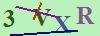

3VXR
StartingStarting FORREST
Starting HANCOCK
 DESOTO
Starting HARRISON
Starting StartingLAMAR
 MARION
StartingStarting  YAZOO
PERRY
Starting JACKSON
Jackson Number of offenders: 416
LAMAR Number of offenders: 91
HANCOCK Number of offenders: 246
YAZOO Number of offenders: 264
DESOTO Number of offenders: 477
FORREST Number of offenders: 276
PERRY Number of offenders: 37
HARRISON Number of offenders: 643
MARION Number of offenders: 252
JACKSON Processed 50
HANCOCK Processed 50
Exiting PERRY

DESOTO Processed 50
MARION Processed 50
HARRISON Processed 50
FORREST Processed 50
LAMAR Processed 50
JACKSON Processed 100
YAZOO Processed 50
HANCOCK Processed 100
DESOTO Processed 100
MARION Processed 100
Exiting LAMAR

FORREST Processed 100
HARRISON Processed 100
JACKSON Processed 150
HANCOCK Processed 150
DESOTO Processed 150
JACKSON Processed 200
MARION Processed 150
FORREST Processed 150
HARRISON Processed 150
YAZOO Processed 100
HANCOCK Processed 200
JACKSON Processed 250
DESOTO Processed 200

In [13]:
threads = []
thread_id = 1

# Get a captcha key for the counties that require captchas
is_captcha_matched = False
while not is_captcha_matched:
    captcha_data = requests.get('https://omsweb.public-safety-cloud.com/jtclientweb/captcha/getnewcaptchaclient')
    image = captcha_data.json()['captchaImage']

    # To be used later for automated captcha solver
    # # Save the image to a file
    # import base64
    # import matplotlib.pyplot as plt
    # img = image.split('base64,')[-1]
    # x = base64.decodebytes(img.encode('ascii'))
    # with open('captcha.jpg', 'wb') as f:
    #     f.write(x)

    html = f'<img src="{image}"/>'
    IPython.display.display(IPython.display.HTML(html))
    user_code = input()

    captcha_response_data = requests.post(
        'https://omsweb.public-safety-cloud.com/jtclientweb/Captcha/validatecaptcha',
        json={'userCode': user_code, 'captchaKey': captcha_data.json()['captchaKey']}
    )
    is_captcha_matched = captcha_response_data.json()['captchaMatched']
    captcha_key = captcha_response_data.json()['captchaKey']

    if not is_captcha_matched:
        print("Incorrect captcha")

for county in CountyWithCaptcha:
    thread = WebScraperThread(thread_id, county, captcha_key)
    threads.append(thread)
    thread_id += 1

for county in CountyWithoutCaptcha:
    thread = WebScraperThread(thread_id, county)
    threads.append(thread)
    thread_id += 1

for t in threads:
    t.start()

# Wait for all threads to complete
for t in threads:
    t.join()

print("Finished scraping")